In [1]:
%load_ext autoreload
%autoreload 2


# Fron https://arxiv.org/pdf/2405.00117
# https://github.com/justinengelmann/RETFound_Green

In [2]:
import albumentations as A
import cv2
import interpretability_toolkit.attributions as attr
import matplotlib.pyplot as plt
import timm
import torch
from albumentations.pytorch import ToTensorV2
from interpretability_toolkit.utils.plots import plot_images_heatmaps
from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_INCEPTION_STD,
)

Attribution = attr.Attribution


c:\Users\cleme\miniconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\cleme\miniconda3\envs\torch\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
model = timm.create_model('vit_small_patch14_reg4_dinov2', pretrained=False, img_size=392, num_classes=0).eval()

rfg_weights = torch.load('../ckpts/retfoundgreen_statedict.pth')
model.load_state_dict(rfg_weights)


<All keys matched successfully>

In [4]:

from torchvision.transforms import v2 as T
from torchvision.io import read_image

transforms = T.Compose([T.Resize((392, 392), antialias=True),
                        T.ToDtype(torch.float32, scale=True),
                        T.Normalize((0.5,), (0.5,))])



img = read_image('fundus.png')
img = transforms(img)
# add dummy batch dimension
img = img.unsqueeze(0)


Generating heatmap with method:  attention_rollout
Generating heatmap with method:  chefer
Generating heatmap with method:  focused_attention


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


Restoring the model to its original state.


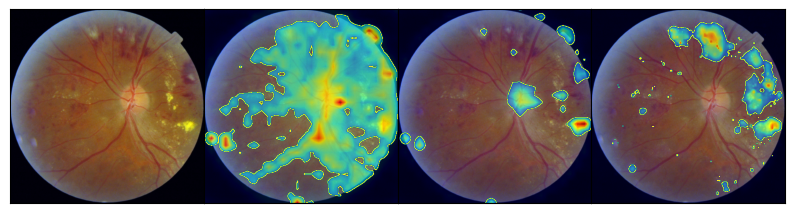

In [15]:
model = model.cuda(0)
attr = Attribution(model, sampling_points=1024, with_replacement=True, temperature=1.2, dilate_tokens=False, 
                   attribution_method='chefer', noise_level=.0) 

img = img.cuda(0)

methods = ["attention_rollout", "chefer", 
           "focused_attention"
           ]
attributions = []
for m in methods:
    print("Generating heatmap with method: ", m)
    with torch.no_grad():
        pred = model(img) # In the supervised setting, we would use the DR prediction here. 
    pred = torch.round(pred)
    head_fusion = "mean" if m == "chefer" else "min"
    with torch.autocast('cuda'):

        a = attr.attribute(img, method=m, 
                           output=pred, 
                           discard_ratio=0.5, 
                           start_from=0, # Choose which attention layer to start from the attribution process (0 is the first, negative indexing is valid)
                           as_regression=True,
                           head_fusion=head_fusion)
    attributions.append(torch.nan_to_num(a, nan=0.0))

fig = plot_images_heatmaps(img, attributions, border_width=3, cmap='jet', threshold='otsu', use_sigmoid=True)

plt.savefig("vit_attributions_retfound_green.png", bbox_inches='tight', pad_inches=0, dpi=300)
